In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta



In [2]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [3]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
compound_model = keras.models.load_model('cd_clf')

In [7]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 438)               96360     
                                                                 
 batch_normalization (BatchN  (None, 438)              1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 438)               0         
                                                                 
 dense_1 (Dense)             (None, 219)               96141     
                                                                 
 batch_normalization_1 (Batc  (None, 219)              876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 219)               0

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=compound_model.predict, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
6/6 [==============================] - 0s 2ms/step


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Current test

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [64]:

with open("shap_values_fd_test_77", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [43]:
# shap_values[0][0].shape

In [55]:
shap_values = shap_values[0][0]

In [67]:
shap_values

[array([[ 0.        ,  0.        , -0.0174978 ,  0.        , -0.03595787,
          0.00213402, -0.20570896, -0.01403704,  0.        , -0.08720474,
          0.        , -0.01990114,  0.        , -0.04885296, -0.00225078,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.07301899, -0.17863044,  0.        ,  0.01659742,
         -0.02787951,  0.        ,  0.        , -0.01865933,  0.        ,
         -0.01051956, -0.0097819 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -0.00847969, -0.0494301 ,
         -0.07790765,  0.        , -0.00598062,  0.08726442,  0.        ,
          0.        ,  0.        , -0.08819421, -0.11326708,  0.        ,
          0.        ,  0.        , -0.01501155,  0.        ,  0.        ,
          0.        , -0.02866943, -0.01361081,  0.        ,  0.        ,
         -0.04297466,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.

In [68]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 219)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [69]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
256_CD_deep_ulcer,0.609459,0.598912,0.68205,0.765806,0.64835,0.450384,0.0,0.377102,0.44438,0.667302,...,0.27005,0.268483,0.0,0.711803,0.243749,0.0,0.34524,0.380147,0.0,0.0


In [70]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 11ms/step
Prediction probabilities for patient: [0.04208937 0.8150951  0.14281544]
Predicted class:


#### Control

In [25]:
import shap

In [71]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [28]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [29]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [72]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

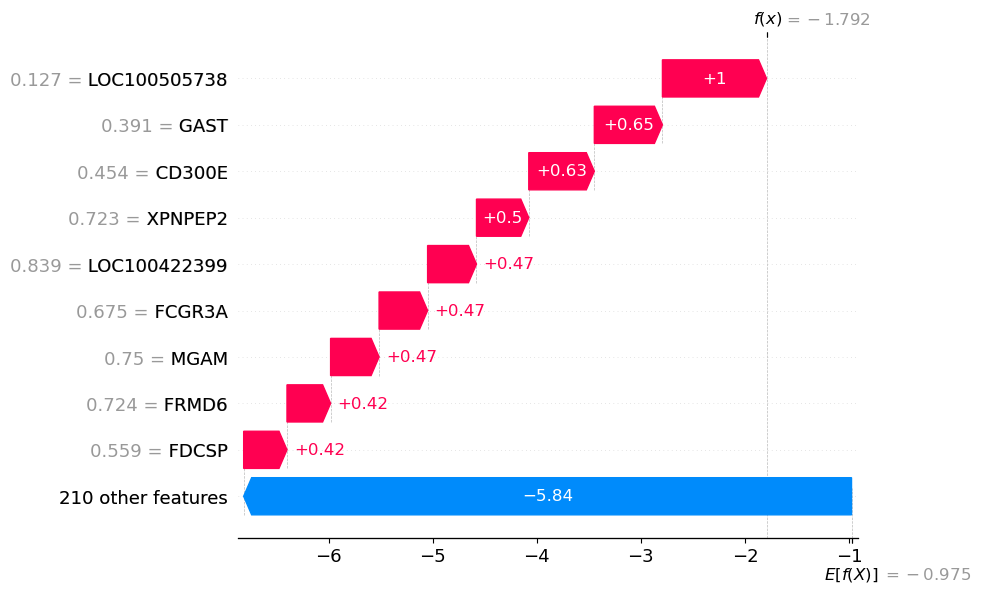

In [73]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent

In [92]:


with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [93]:
# shap_values = shap_values[0]

In [94]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 219)


In [95]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
256_CD_deep_ulcer,0.609459,0.598912,0.68205,0.765806,0.64835,0.450384,0.0,0.377102,0.44438,0.667302,...,0.27005,0.268483,0.0,0.711803,0.243749,0.0,0.34524,0.380147,0.0,0.0


In [96]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 11ms/step
Prediction probabilities for patient: [0.04208937 0.8150951  0.14281544]
Predicted class:


#### Control

In [97]:
import shap

In [98]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx, :], patient, link="logit")

####  CD no ulcer

In [99]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [100]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [101]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][idx,:], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

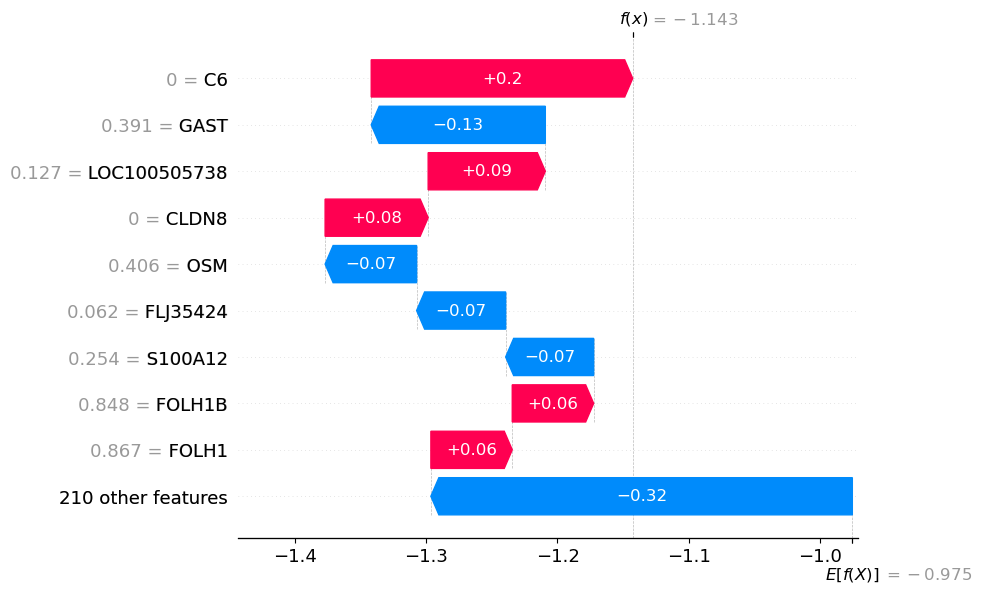

In [102]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## KL divergence (wrong way)

In [74]:


with open("shap_values_fd_kl", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [75]:
shap_values = shap_values[0]

In [76]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 219)


In [77]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
256_CD_deep_ulcer,0.609459,0.598912,0.68205,0.765806,0.64835,0.450384,0.0,0.377102,0.44438,0.667302,...,0.27005,0.268483,0.0,0.711803,0.243749,0.0,0.34524,0.380147,0.0,0.0


In [78]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 11ms/step
Prediction probabilities for patient: [0.04208937 0.8150951  0.14281544]
Predicted class:


#### Control

In [79]:
import shap

In [80]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx, :], patient, link="logit")

####  CD no ulcer

In [81]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [82]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [83]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][idx,:], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

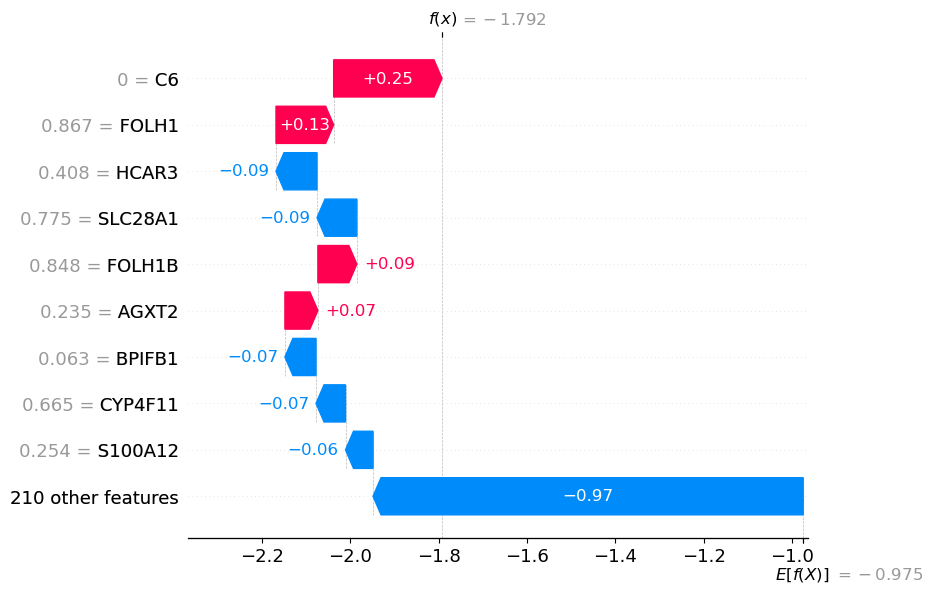

In [84]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))